In [1]:
import pandas as pd
import numpy as np
import pymysql
import seaborn as sns
import matplotlib.pyplot as plt

from dotenv import load_dotenv
import os

load_dotenv()
%matplotlib inline
sns.set(style="darkgrid")

In [ ]:
HOSTNAME = os.getenv("HOSTNAME")
USER_NAME = os.getenv("USER_NAME")
PASSWORD = os.getenv("PASSWORD")
DATABASE_NAME = os.getenv("DATABASE_NAME")

In [2]:
# Connect to the database, host público do google Cloud SQL, conexão permitida a partir do IP de rede
# Importante manter os dados do banco de dados em variáveis de ambiente
connection = pymysql.connect(
    host=HOSTNAME,
    user=USER_NAME,
    password=PASSWORD,
    database=DATABASE_NAME)

# Loading the table as a DataFrame
df = pd.read_sql("SELECT * FROM transactional_sample", connection)
connection.close()

C:\Users\repires\AppData\Local\Temp\1\ipykernel_19080\603101693.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM transactional_sample", connection)


In [3]:
df["transaction_date"] = pd.to_datetime(df["transaction_date"])
df["transaction_hour"] = df["transaction_date"].dt.hour

df.head(10)

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk,transaction_hour
0,21320398,29744,97051,434505******9116,2019-12-01 23:16:33,374.56,285475,0,23
1,21320399,92895,2708,444456******4210,2019-12-01 22:45:38,734.87,497105,1,22
2,21320400,47759,14777,425850******7024,2019-12-01 22:22:43,760.36,,0,22
3,21320401,68657,69758,464296******3991,2019-12-01 21:59:20,2556.13,,1,21
4,21320402,54075,64367,650487******6116,2019-12-01 21:30:53,55.36,860232,0,21
5,21320403,59566,40759,516292******8220,2019-12-01 21:25:53,60.49,192705,0,21
6,21320404,20917,25661,650485******9310,2019-12-01 21:25:20,318.37,760932,0,21
7,21320405,56107,81152,650516******9201,2019-12-01 21:24:06,188.68,486,1,21
8,21320406,56107,81152,650516******9201,2019-12-01 21:13:22,352.77,486,1,21
9,21320407,56107,81152,650516******9201,2019-12-01 21:04:55,345.68,486,1,21


In [4]:
df.columns

Index(['transaction_id', 'merchant_id', 'user_id', 'card_number',
       'transaction_date', 'transaction_amount', 'device_id', 'has_cbk',
       'transaction_hour'],
      dtype='object')

<Figure size 1400x500 with 0 Axes>

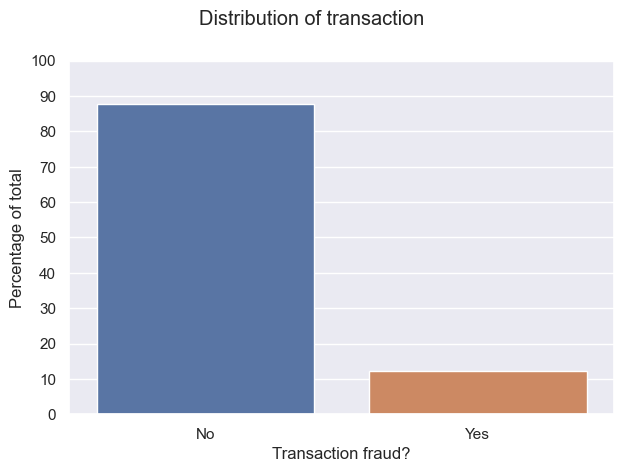

In [5]:
# Plot distribution of transaction with fraud and without fraud
plt.figure(figsize=(14, 5))
fig, ax = plt.subplots(1)
plt.suptitle("Distribution of transaction")

sns.barplot(x="has_cbk", y="transaction_id", data=df, estimator=lambda x: len(x) / len(df) * 100)

plt.xlabel("Transaction fraud?")
plt.ylabel("Percentage of total")
plt.xticks([0, 1], ["No", "Yes"])
plt.yticks(np.arange(0, 110, 10))

plt.tight_layout()

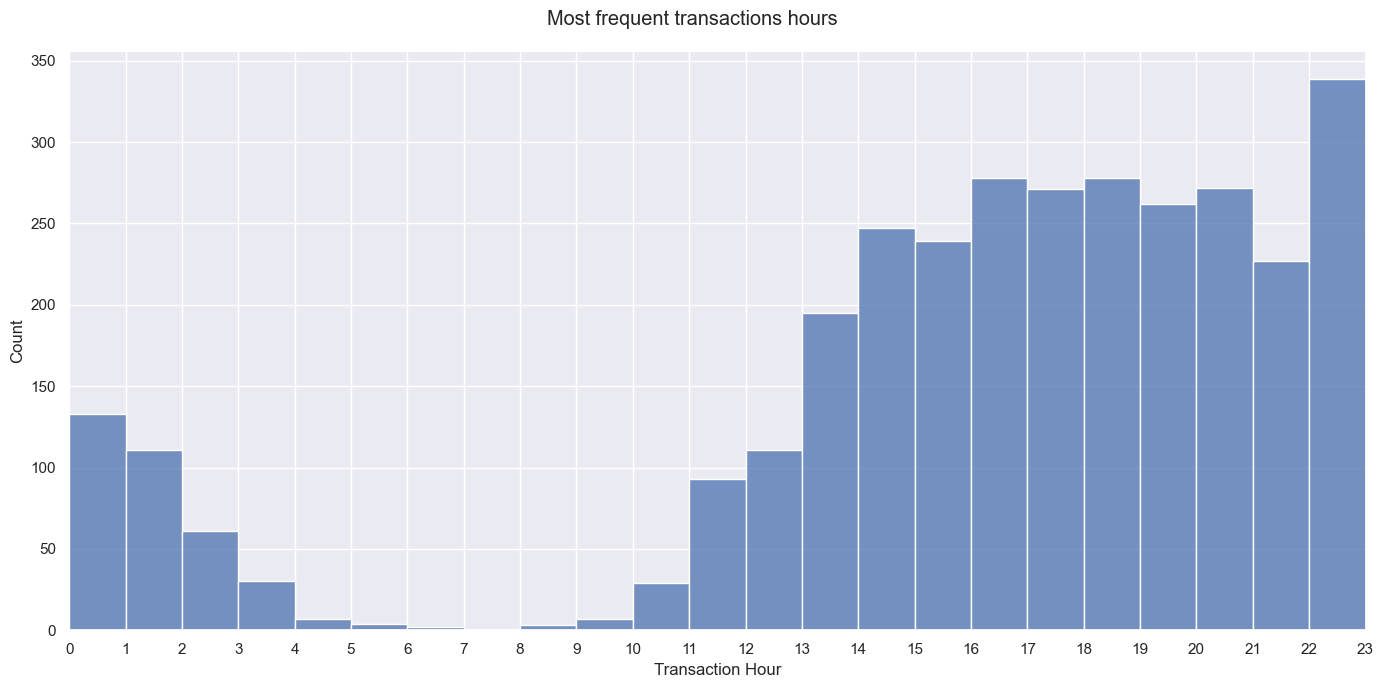

In [6]:
fig, ax = plt.subplots(1,1, figsize = (14,7))

fig.suptitle("Most frequent transactions hours")

sns.histplot(data=df, x="transaction_hour", bins=range(0,24))
plt.xlim(0, 23)
plt.xticks(range(0,24))
plt.xlabel("Transaction Hour")
plt.tight_layout()

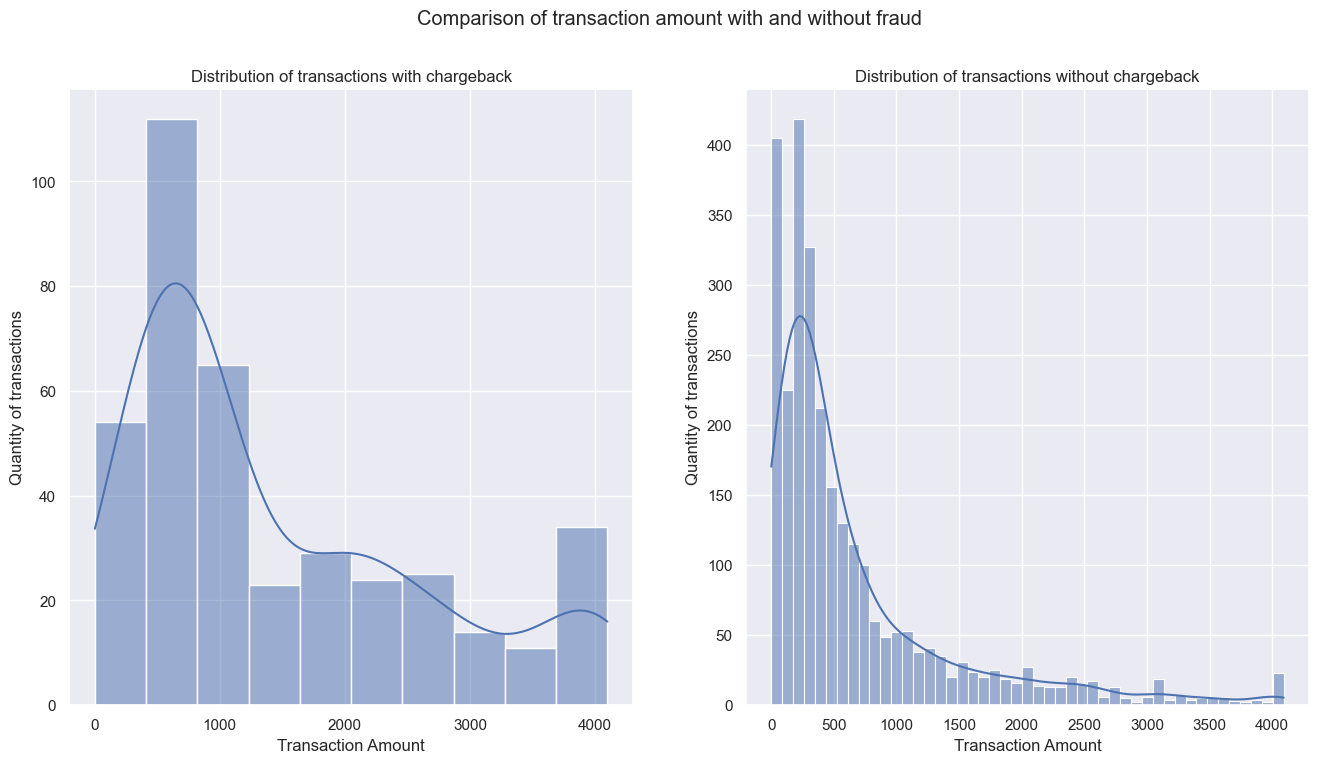

In [7]:
# Histogram of transaction amount with fraud detected
fig, ax = plt.subplots(1,2,figsize=(16,8))
fig.suptitle("Comparison of transaction amount with and without fraud")

sns.histplot(df.loc[df["has_cbk"] == 1].transaction_amount,kde=True, ax=ax[0]).set_title("Distribution of transactions with chargeback")
sns.histplot(df.loc[df["has_cbk"] == 0].transaction_amount,kde=True, ax=ax[1]).set_title("Distribution of transactions without chargeback")

for i in range(2):
    ax[i].set_xlabel("Transaction Amount")
    ax[i].set_ylabel("Quantity of transactions")

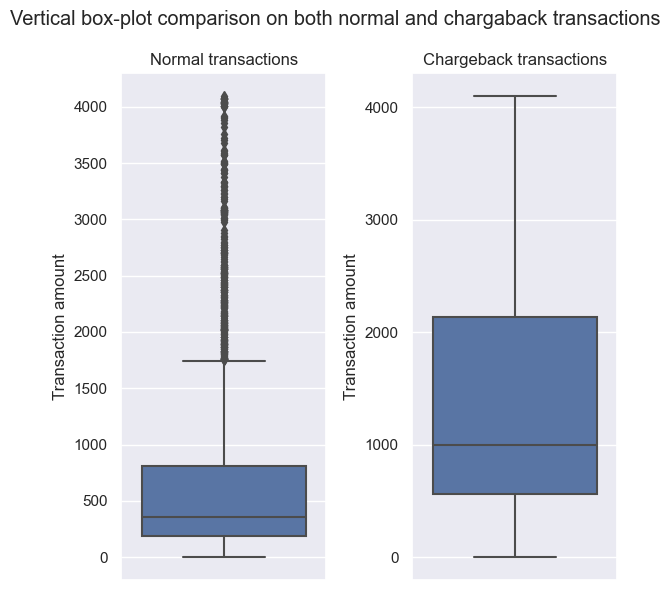

In [8]:
df_norm = df[df["has_cbk"] == 0]
df_cbk = df[df["has_cbk"] == 1]

fig, ax = plt.subplots(1,2,figsize=(6,6))

sns.boxplot(data = df_norm, y="transaction_amount", ax=ax[0]).set_title("Normal transactions")
sns.boxplot(data = df_cbk, y="transaction_amount", ax=ax[1]).set_title("Chargeback transactions")

ax[0].set_ylabel("Transaction amount")
ax[1].set_ylabel("Transaction amount")

fig.suptitle("Vertical box-plot comparison on both normal and chargaback transactions")
fig.tight_layout()

In [9]:
# Quantity of transactions with chargeback by weekday
df["day_of_week"] = df["transaction_date"].dt.day_name()

# Transaction_id occur each day when has_cbk = 1
df_cbk = df[df["has_cbk"] == 1].groupby("day_of_week").transaction_id.nunique()
df_cbk.sort_values(ascending=False, inplace=True)

day_of_week
Friday       120
Monday        20
Saturday      99
Sunday        41
Thursday      61
Tuesday       16
Wednesday     34
Name: transaction_id, dtype: int64

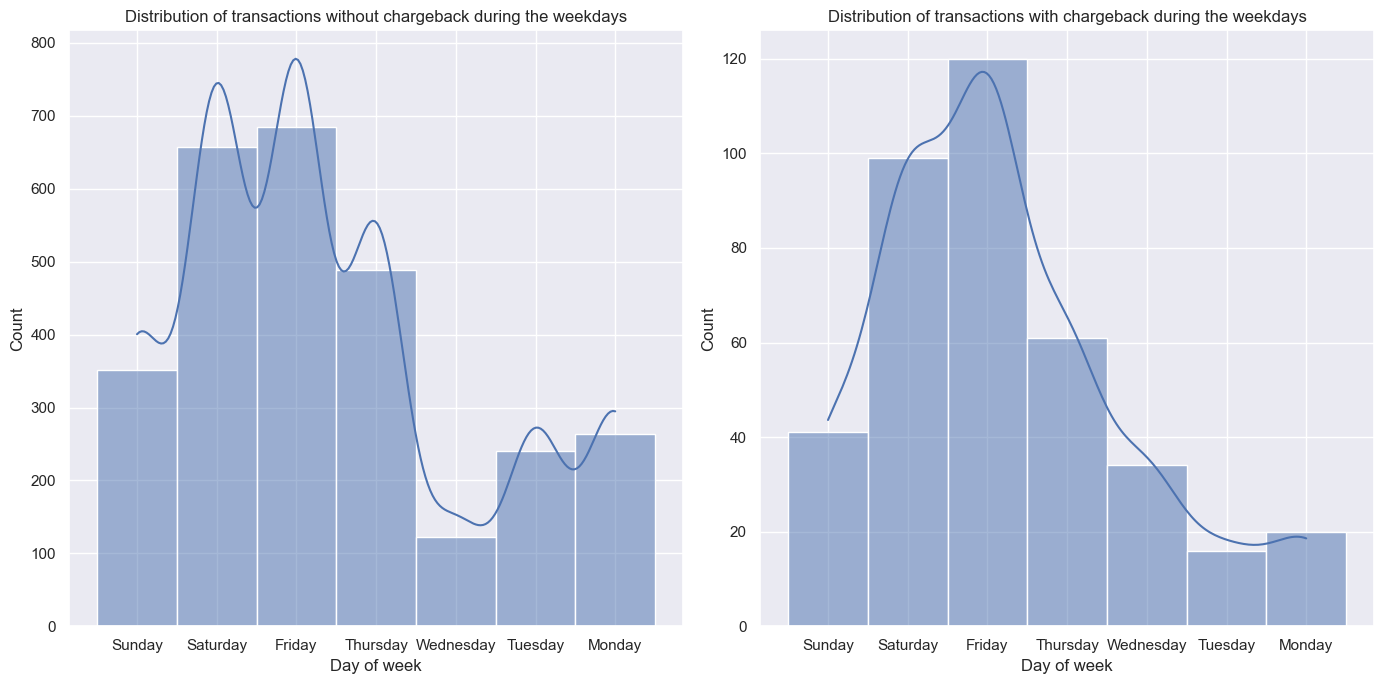

In [10]:
fig, ax = plt.subplots(1,2,figsize=(14,7))
sns.histplot(df.loc[df["has_cbk"] == 0].day_of_week,kde=True, ax=ax[0]).set_title("Distribution of transactions without chargeback during the weekdays")
ax[0].set_xlabel("Day of week")

sns.histplot(df.loc[df["has_cbk"] == 1].day_of_week,kde=True, ax=ax[1]).set_title("Distribution of transactions with chargeback during the weekdays")
ax[1].set_xlabel("Day of week")
plt.tight_layout()

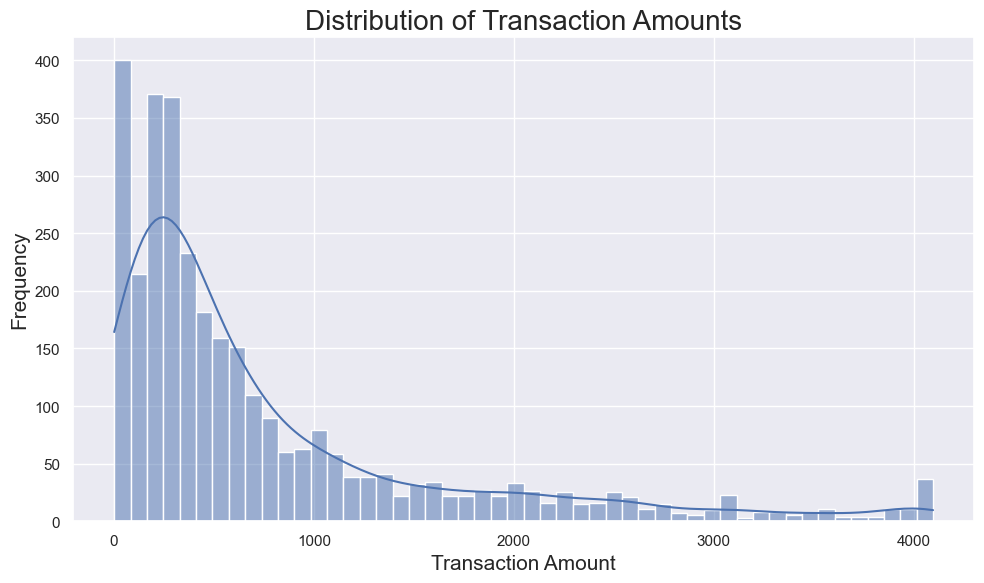

In [11]:
plt.figure(figsize=(10,6))
sns.histplot(df["transaction_amount"], bins=50, kde=True)
plt.title("Distribution of Transaction Amounts", fontsize=20)
plt.xlabel("Transaction Amount", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.tight_layout()

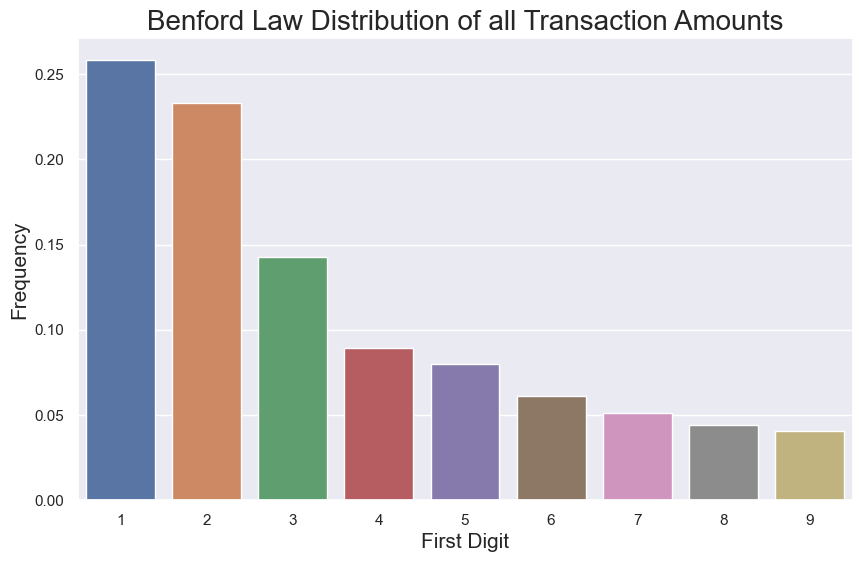

In [12]:
# Creating a Benford's Law plot of the transaction_amount of the whole dataset
benford_data = df["transaction_amount"].apply(lambda x: str(x)[0])
benford_data = benford_data.value_counts(normalize=True).sort_index()

#plotting the distribution of the transaction
plt.figure(figsize=(10,6))
sns.barplot(x=benford_data.index, y=benford_data.values)
plt.title("Benford Law Distribution of all Transaction Amounts", fontsize=20)
plt.xlabel("First Digit", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.show()

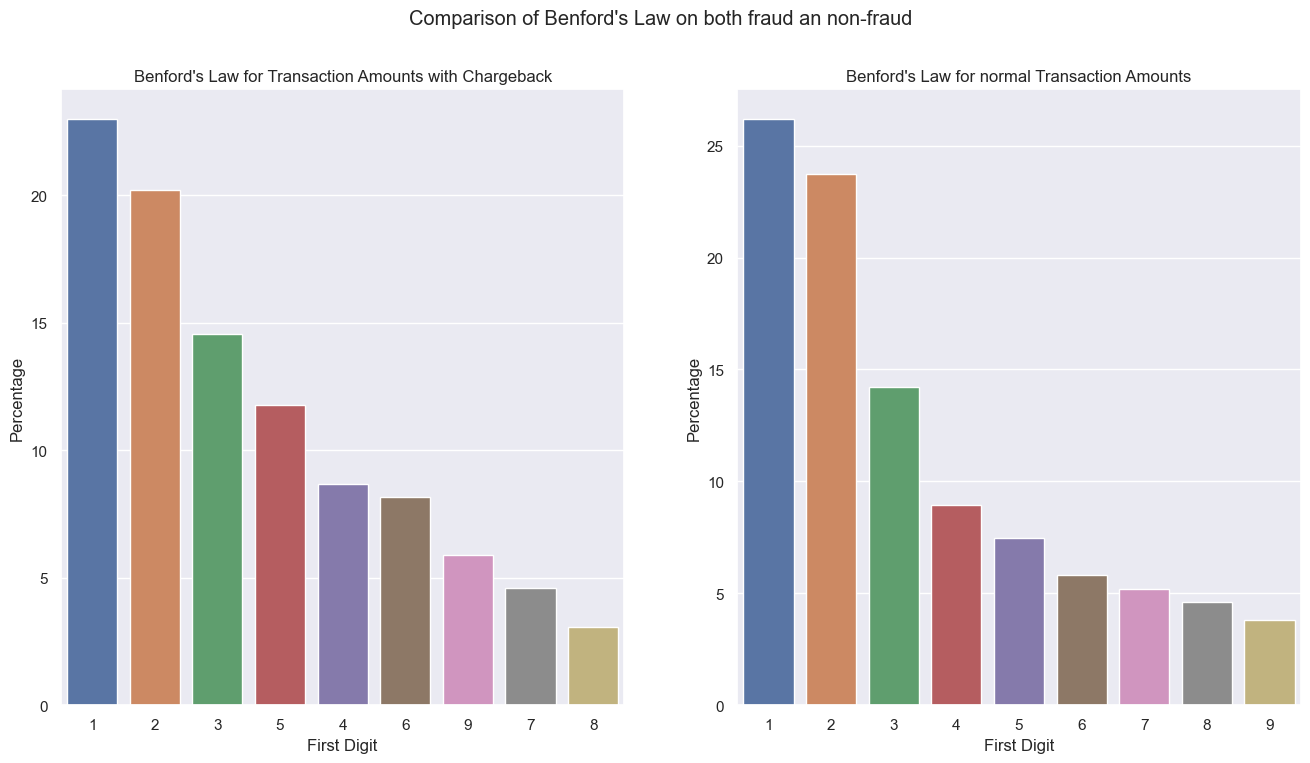

In [13]:
# subset with only the transaction_amount and has_cbk columns
df_subset = df[["transaction_amount", "has_cbk"]]

fig, ax = plt.subplots(1,2,figsize=(16,8))
fig.suptitle("Comparison of Benford's Law on both fraud an non-fraud")

for i, has_cbk in enumerate([1,0]):
    # Filter the data frame to only include transactions with has_cbk = 1 or 0
    df_filtered = df_subset[df_subset["has_cbk"] == has_cbk]

    # list of the first digits of the transaction amounts
    first_digits = [str(x)[0] for x in df_filtered["transaction_amount"]]

    # Dictionary of the counts of the first digits
    counts = {x: first_digits.count(x) for x in first_digits}

    # Create a data frame from the dictionary
    df_counts = pd.DataFrame.from_dict(counts, orient="index", columns=["counts"])
    df_counts["percentage"] = df_counts["counts"] / df_counts["counts"].sum() * 100

    # Plottings
    sns.barplot(x=df_counts.index, y="percentage", data=df_counts, order=df_counts["percentage"].sort_values(ascending=False).index, ax=ax[i])
    ax[i].set_xlabel("First Digit")
    ax[i].set_ylabel("Percentage")
    if has_cbk == 1:
        ax[i].set_title("Benford's Law for Transaction Amounts with Chargeback")
    else:
        ax[i].set_title("Benford's Law for normal Transaction Amounts")

plt.show()

In [14]:
# Detecting cards with unusual number of transactions, rule-based analysis whith more than 2 transactions with at least 1 chargeback
# Group the transactions by card number and count the number of transactions for each card and filter by the rule
card_counts_cbk = df[df["has_cbk"] == 1].groupby("card_number").size().reset_index(name="transactions_cbk")
card_counts_cbk = card_counts_cbk.sort_values(by="transactions_cbk", ascending=False)
suspects_cards = card_counts_cbk[card_counts_cbk["transactions_cbk"] > 2]

# Filter the original dataframe to show only cards that match the rule
suspects_cards = df[df["card_number"].isin(suspects_cards["card_number"])]
suspects_cards.sort_values(by="card_number", ascending=False)

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk,transaction_hour,day_of_week
1314,21321712,89943,86411,651653******2256,2019-11-24 21:09:36,1872.98,597308,1,21,Sunday
1072,21321470,89943,86411,651653******2256,2019-11-27 19:51:01,2030.64,597308,1,19,Wednesday
1803,21322201,89943,86411,651653******2256,2019-11-22 19:11:14,1979.46,597308,1,19,Friday
1431,21321829,89943,86411,651653******2256,2019-11-23 19:54:02,1952.18,597308,1,19,Saturday
2082,21322480,89943,86411,651653******2256,2019-11-21 21:37:36,140.38,597308,1,21,Thursday
...,...,...,...,...,...,...,...,...,...,...
596,21320994,1308,96025,406655******7343,2019-11-29 16:46:59,2288.47,438940,1,16,Friday
692,21321090,1308,79054,406655******7343,2019-11-29 12:51:18,2231.98,101848,1,12,Friday
709,21321107,1308,96025,406655******5764,2019-11-29 11:32:14,2412.28,438940,1,11,Friday
723,21321121,1308,96025,406655******5764,2019-11-29 03:30:44,2486.70,438940,1,3,Friday


In [15]:
# Detecting users with unusual number of transactions
user_id_counts = df.groupby("user_id").size().reset_index(name="transactions")
user_id_counts = user_id_counts.sort_values(by="transactions", ascending=False)

# Detecting users with unusual number of transactions that already had fraud chargeback label
user_frauds = df[df["has_cbk"] == 1].groupby("user_id").size().reset_index(name="transactions with fraud")

# table to check the users Fraud rate based on un
result = pd.merge(user_id_counts, user_frauds, on="user_id",sort=True)
result["Fraud rate"] = round(result["transactions with fraud"]/result["transactions"]*100,2)

result.sort_values(by="transactions", ascending=False)

,user_id,transactions,transactions with fraud,Fraud rate
19,11750,31,25,80.65
136,91637,22,19,86.36
114,79054,17,15,88.24
144,96025,14,13,92.86
113,78262,13,12,92.31
...,...,...,...,...
71,50699,1,1,100.00
68,45420,1,1,100.00
67,45031,1,1,100.00
65,44494,1,1,100.00


In [16]:
#Detecting cards with unusual number of transactions
# Group the data by card_id and count the number of transactions per card_id
card_id_counts = df.groupby("card_number").size().reset_index(name="transactions")
card_id_counts = card_id_counts.sort_values(by="transactions", ascending=False)

#Detecting users with unusual number of transactions that already had fraud chargeback label
card_frauds = df[df["has_cbk"] == 1].groupby("card_number").size().reset_index(name="transactions with fraud")

# table to check if the cards with many transactions had many fraud transactions also
result = pd.merge(card_id_counts, card_frauds, on="card_number",sort=True)
result["Fraud rate"] = round(result["transactions with fraud"]/result["transactions"]*100,2)

result.sort_values(by="transactions", ascending=False)

,card_number,transactions,transactions with fraud,Fraud rate
238,554482******7640,10,10,100.0
165,530034******3859,6,6,100.0
273,651653******2256,5,5,100.0
120,498406******7104,4,4,100.0
256,606282******5785,4,3,75.0
...,...,...,...,...
109,498401******2440,1,1,100.0
110,498401******4043,1,1,100.0
111,498401******4982,1,1,100.0
112,498401******6342,1,1,100.0


In [17]:
# group by merchant_id and count the number of transactions
merchant_id_grouped = df.groupby("merchant_id").size().reset_index(name="transactions")

# group by merchant_id and count the number of chargebacks (has_cbk=1)
chargebacks_grouped = df[df["has_cbk"] == 1].groupby("merchant_id").size().reset_index(name="transactions with fraud")

# merge the two grouped dataframes on merchant_id
merchant_analysis = merchant_id_grouped.merge(chargebacks_grouped, on="merchant_id", how="left")
merchant_analysis = merchant_analysis.fillna(0)

# calculate the chargeback rate as chargebacks_count / transactions_count
merchant_analysis["Fraud rate"] = merchant_analysis["transactions with fraud"] / merchant_analysis["transactions"] * 100
merchant_analysis["Fraud rate"] = round(merchant_analysis["Fraud rate"],2)

In [18]:
# Rule based check table, where merchant had more than one transaction and at least one chargeback
merchant_analysis[(merchant_analysis["transactions"]>1) & (merchant_analysis["transactions with fraud"]>0)]

,merchant_id,transactions,transactions with fraud,Fraud rate
20,1308,15,15.0,100.00
52,3531,2,2.0,100.00
70,4153,6,5.0,83.33
77,4705,22,19.0,86.36
97,5404,4,1.0,25.00
...,...,...,...,...
1637,92895,2,1.0,50.00
1655,94198,2,1.0,50.00
1713,97291,7,4.0,57.14
1729,98272,5,3.0,60.00
